# ANN for NYC taxi fare predictions

In [66]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [67]:
df = pd.read_csv('./Data/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [68]:
df.describe()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,10.040326,0.333333,-73.976626,40.751443,-73.974501,40.751695,1.347167
std,7.500134,0.471406,0.031497,0.025821,0.032419,0.030279,0.759263
min,2.500000,0.000000,-74.465447,40.121653,-74.443323,40.164927,1.000000
25%,5.700000,0.000000,-73.992386,40.736594,-73.991478,40.735914,1.000000
50%,7.700000,0.000000,-73.982084,40.753661,-73.980411,40.754441,1.000000
75%,11.300000,1.000000,-73.968710,40.768020,-73.965500,40.768880,1.000000
max,49.900000,1.000000,-73.311845,40.981292,-73.496140,40.993498,5.000000


In [69]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [70]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [71]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = df.apply(lambda x: 'pm' if x['hour'] > 12 else 'am', axis=1)
df['weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,hour,AMorPM,weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [72]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'hour', 'AMorPM', 'weekday'],
      dtype='object')

In [73]:
cat_cols = ['hour', 'AMorPM', 'weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']

In [74]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')
cat_data = np.stack([df[col].cat.codes.values for col in cat_cols], 1)
cat_data = torch.tensor(cat_data, dtype=torch.int64)
cat_data[:3]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2]])

In [75]:
cont_data = np.stack([df[col].values for col in cont_cols], 1)
cont_data = torch.tensor(cont_data, dtype=torch.float)
cont_data[:3]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268]])

In [76]:
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)
y[:3]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000]])

In [77]:
n = y.shape[0]
test_size = int(0.2*n)

cat_train = cat_data[:n-test_size]
cat_test = cat_data[n-test_size:n]

con_train = cont_data[:n-test_size]
con_test = cont_data[n-test_size:n]

y_train = y[:n-test_size]
y_test = y[n-test_size:n]

In [78]:
# calculate embedding sizes to create each nn.Embedding
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [79]:
class Model(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.25):
        super().__init__()
        # create embeding for each category in categorical data
        self.embeds = nn.ModuleList([nn.Embedding(n_embs, n_dim) for n_embs, n_dim in emb_szs])
        self.emb_drop = nn.Dropout(p)
        
        # normalize the continuous data
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        
        # total num of embeddings
        n_emb = sum((n_dim for _,n_dim in emb_szs))
        n_in = n_emb + n_cont
        
        for num_nodes in layers:
            layerlist.append(nn.Linear(n_in,num_nodes)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(num_nodes))
            layerlist.append(nn.Dropout(p))
            n_in = num_nodes
            
        # create output layer
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:, i]))
        
        # create tensor or categorical data
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        # concat tensor of continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # pass data through the nn layers
        x = self.layers(x)
        return x

In [80]:
n_cont = cont_data.shape[1]
n_out = 1 # predicting one fare price
layers = [200, 100] # num nodes in each layer

model = Model(emb_szs, n_cont, n_out, layers, p=0.25)

In [81]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [86]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    if i%25 == 1 or i == epochs-1:
        print(f'epoch: {i:3}  loss: {loss.item():10.3f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'Duration: {time.time() - start_time:.0f} seconds')

epoch:   1  loss:     10.818
epoch:  26  loss:      9.552
epoch:  51  loss:      8.621
epoch:  76  loss:      7.579
epoch: 101  loss:      6.351
epoch: 126  loss:      5.009
epoch: 151  loss:      3.848
epoch: 176  loss:      3.308
epoch: 201  loss:      3.237
epoch: 226  loss:      3.202
epoch: 251  loss:      3.176
epoch: 276  loss:      3.158
epoch: 299  loss:      3.142
Duration: 710 seconds


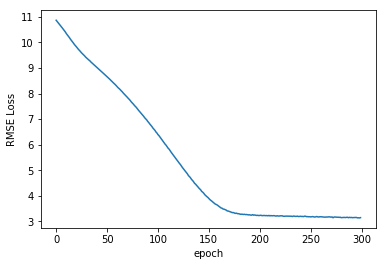

In [87]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [111]:
con_test_df = pd.DataFrame(con_test, columns=cont_cols, dtype=float)
cat_test_df = pd.DataFrame(cat_test, columns=cat_cols, dtype=int)

test_df = pd.concat([con_test_df, cat_test_df], axis=1)
test_df['fare_amount'] = y_test.numpy()
test_df.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,dist_km,hour,AMorPM,weekday,fare_amount
0,40.740097,-73.986443,40.712433,-74.009079,1.0,3.619559,19,1,0,8.1
1,40.703072,-74.011528,40.737419,-73.979385,3.0,4.682050,10,0,2,12.1
2,40.743656,-73.989189,40.732746,-73.991364,1.0,1.226629,4,0,0,4.9
3,40.815472,-73.958847,40.752586,-74.005989,1.0,8.040117,8,0,0,15.3
4,40.765785,-73.963425,40.769913,-73.990341,1.0,2.312771,4,0,4,11.3


In [115]:
with torch.no_grad():
    y_pred = model.forward(cat_test, con_test)
    test_df['pred'] = y_pred.numpy()
    loss = torch.sqrt(criterion(y_pred, y_test))
test_df['diff'] = test_df.apply(lambda row: row['fare_amount'] - row['pred'], axis=1)
print(f'RMSE: {loss:.8f}')

RMSE: 3.20669651


In [120]:
test_df[['fare_amount', 'pred', 'diff']]

,fare_amount,pred,diff
0,8.100000,9.500976,-1.400975
1,12.100000,13.791042,-1.691042
2,4.900000,5.611048,-0.711048
3,15.300000,17.512083,-2.212083
4,11.300000,9.338019,1.961981
5,16.500000,20.291964,-3.791964
6,3.300000,4.402055,-1.102055
7,4.500000,6.784189,-2.284189
8,5.700000,6.240925,-0.540926
9,20.100000,23.587925,-3.487925


In [123]:
test_df['diff'].describe()

count    24000.000000
mean         0.060414
std          3.206194
min        -45.095567
25%         -1.217611
50%         -0.265849
75%          0.891006
max         45.731939
Name: diff, dtype: float64